# Initialising the environment

First we set up the environment:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats

Next we read the data. The data comes from the UCI repository. The data set contains information about breast cancer patients. The variable that we are trying to predict is whether there will be recurrence or not. These are the variables in the data set:

* Class: no-recurrence-events, recurrence-events
* age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
* menopause: lt40, ge40, premeno.
* tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
* inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
* node-caps: yes, no.
* deg-malig: 1, 2, 3.
* breast: left, right.
* breast-quad: left-up, left-low, right-up, right-low, central.
* irradiat: yes, no.

We download the data set and name the columns:


In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data",
                 header=None)
# label columns
df.columns = ["class", "age", "menopause", "tumor_size",
                    "inv_nodes", "node_caps", "deg_malig",
                    "breast", "breast_quad", "irradiat"]

# Cleaning the data

We check for missing values:

In [3]:
df.isnull().sum()

class          0
age            0
menopause      0
tumor_size     0
inv_nodes      0
node_caps      0
deg_malig      0
breast         0
breast_quad    0
irradiat       0
dtype: int64

Look at the types of the columns:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor_size   286 non-null    object
 4   inv_nodes    286 non-null    object
 5   node_caps    286 non-null    object
 6   deg_malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast_quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


Let us look at the values of the object variables:

In [5]:
df["class"].value_counts()

no-recurrence-events    201
recurrence-events        85
Name: class, dtype: int64

In [6]:
df["age"].value_counts()

50-59    96
40-49    90
60-69    57
30-39    36
70-79     6
20-29     1
Name: age, dtype: int64

In [7]:
df["tumor_size"].value_counts()

30-34    60
25-29    54
20-24    50
15-19    30
10-14    28
40-44    22
35-39    19
0-4       8
50-54     8
5-9       4
45-49     3
Name: tumor_size, dtype: int64

In [8]:
df["inv_nodes"].value_counts()

0-2      213
3-5       36
6-8       17
9-11      10
15-17      6
12-14      3
24-26      1
Name: inv_nodes, dtype: int64

In [9]:
df["menopause"].value_counts()

premeno    150
ge40       129
lt40         7
Name: menopause, dtype: int64

In [10]:
df["node_caps"].value_counts()

no     222
yes     56
?        8
Name: node_caps, dtype: int64

In [11]:
df["breast"].value_counts()

left     152
right    134
Name: breast, dtype: int64

In [12]:
df["irradiat"].value_counts()

no     218
yes     68
Name: irradiat, dtype: int64

In [13]:
df["breast_quad"].value_counts()

left_low     110
left_up       97
right_up      33
right_low     24
central       21
?              1
Name: breast_quad, dtype: int64

We note that in somce cases there are question marks. We should treat them like missing values:

In [14]:
df.replace("?", np.nan, inplace=True)
df.isnull().sum()
# now we have nan values. drop these observations
df.dropna(inplace=True)

# Visualizing the data

Let us plot a figure that will help visualise the distribution of both classes in each group of the categorical variables:

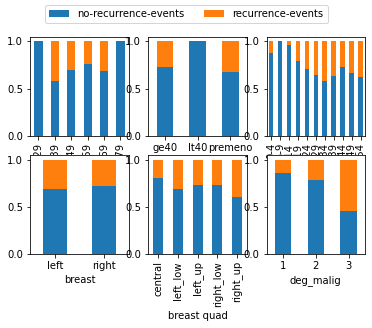

In [15]:
fig, ax = plt.subplots(2, 3)

long = df[["class", "age"]].groupby(["age", "class"]).size().reset_index(name="count").pivot(index="age", columns="class", values="count")
long["total"] = long.sum(axis=1)
long["no-recurrence-events"] = long["no-recurrence-events"] / long["total"]
long["recurrence-events"] = long["recurrence-events"] / long["total"]
long.drop("total", axis=1, inplace=True)
long.plot(kind="bar", stacked=True, ax=ax[0,0])
ax[0,0].set_xlabel("age")
ax[0,0].get_legend().remove()

long = df[["class", "menopause"]].groupby(["menopause", "class"]).size().reset_index(name="count").pivot(index="menopause", columns="class", values="count")
long["total"] = long.sum(axis=1)
long["no-recurrence-events"] = long["no-recurrence-events"] / long["total"]
long["recurrence-events"] = long["recurrence-events"] / long["total"]
long.drop("total", axis=1, inplace=True)
long.plot(kind="bar", stacked=True, rot=0, ax=ax[0,1])
ax[0,1].set_xlabel("menopause")
ax[0,1].get_legend().remove()

long = df[["class", "tumor_size"]].groupby(["tumor_size", "class"]).size().reset_index(name="count").pivot(index="tumor_size", columns="class", values="count")
long["total"] = long.sum(axis=1)
long["no-recurrence-events"] = long["no-recurrence-events"] / long["total"]
long["recurrence-events"] = long["recurrence-events"] / long["total"]
long.drop("total", axis=1, inplace=True)
order = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54"]
long.loc[order].plot(kind="bar", stacked=True, ax=ax[0,2])
ax[0,2].set_xlabel("tumor size")
ax[0,2].get_legend().remove()

long = df[["class", "breast"]].groupby(["breast", "class"]).size().reset_index(name="count").pivot(index="breast", columns="class", values="count")
long["total"] = long.sum(axis=1)
long["no-recurrence-events"] = long["no-recurrence-events"] / long["total"]
long["recurrence-events"] = long["recurrence-events"] / long["total"]
long.drop("total", axis=1, inplace=True)
long.plot(kind="bar", stacked=True, rot=0, ax=ax[1,0])
ax[1,0].set_xlabel("breast")
ax[1,0].get_legend().remove()

long = df[["class", "breast_quad"]].groupby(["breast_quad", "class"]).size().reset_index(name="count").pivot(index="breast_quad", columns="class", values="count")
long["total"] = long.sum(axis=1)
long["no-recurrence-events"] = long["no-recurrence-events"] / long["total"]
long["recurrence-events"] = long["recurrence-events"] / long["total"]
long.drop("total", axis=1, inplace=True)
long.plot(kind="bar", stacked=True, ax=ax[1,1])
ax[1,1].set_xlabel("breast quad")
ax[1,1].get_legend().remove()

long = df[["class", "deg_malig"]].groupby(["deg_malig", "class"]).size().reset_index(name="count").pivot(index="deg_malig", columns="class", values="count")
long["total"] = long.sum(axis=1)
long["no-recurrence-events"] = long["no-recurrence-events"] / long["total"]
long["recurrence-events"] = long["recurrence-events"] / long["total"]
long.drop("total", axis=1, inplace=True)
long.plot(kind="bar", stacked=True, rot=0, ax=ax[1,2])
ax[1,2].set_xlabel("deg_malig")
ax[1,2].get_legend().remove()
handles, labels = ax[1,2].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

Looking at the figure above, it would be prudent to perform chi2 tests on each of the variables to measure the significance level of the results. First we convert the variables from type object to type categorical:

In [16]:
df[df.select_dtypes("object").columns] = df.select_dtypes("object").astype("category")

# Bivariate analysis

Now perform the chi2 test on the categorical columns:

In [17]:
# perform chi2 tests
# get categorical columns
categorical = df[df.select_dtypes("category").columns]
# remove the class column
categorical = categorical.loc[:, categorical.columns != "class"]
# now loop and perform chi2 test and save results
chi2_results = pd.DataFrame({"variable": object(), "p-value": float(), "significance": object()}, index=[])
for column in categorical.columns:
    crosstab = pd.crosstab(df["class"], df[column])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    if p < 0.001:
        stars = "***"
    elif p < 0.01:
        stars = "**"
    elif p < 0.05:
        stars = "*"
    elif p>= 0.05:
        stars = ""
    chi2_results = chi2_results.append({"variable": column, "p-value": p, "significance": stars}, ignore_index=True)
chi2_results.sort_values("p-value")

,variable,p-value,significance
4,node_caps,0.000003,***
3,inv_nodes,0.000008,***
7,irradiat,0.000314,***
2,tumor_size,0.040259,*
1,menopause,0.217753,
0,age,0.267487,
6,breast_quad,0.507302,
5,breast,0.578759,


Now perform ttest on the single numeric variable that we have:

In [18]:
col1 = df[df["class"] == "no-recurrence-events"]
col2 = df[df["class"] == "recurrence-events"]
t, p = stats.ttest_ind(col1["deg_malig"], col2["deg_malig"])
if p < 0.001:
    print(p, "***")
elif p < 0.01:
    print(p, "**")
elif p < 0.05:
    print(p, "*")
elif p >= 0.05:
    print(p)

1.7978288102227966e-08 ***


# Machine learning

## Encoding the categorical variables

Many of the categories have a natural order. We reorder so that this natural order is maintained the three columns are age, tumor_size, and inv_nodes:

In [19]:
lb_age = LabelEncoder()
lb_age.fit(["20-29", "30-39", "40-49", "50-59", "60-69", "70-79"])
df["age"] = lb_age.transform(df["age"])

lb_tumor = LabelEncoder()
lb_tumor.fit(["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54"])
df["tumor_size"] = lb_tumor.transform(df["tumor_size"])

lb_nodes = LabelEncoder()
lb_nodes.fit(["0-2", "3-5", "6-8", "9-11", "12-14", "15-17", "24-26"])
df["inv_nodes"] = lb_nodes.transform(df["inv_nodes"])

Now we look at the other columns to make sure that everything looks alright:

In [20]:
df["class"].value_counts()
# let us convert this to factors where 1 means recurrence and 0 means no-recurrence
lb_class = LabelEncoder()
lb_class.fit(["no-recurrence-events", "recurrence-events"])
df["class"] = lb_class.transform(df["class"])

df["menopause"].value_counts()
# Since there are three classes and order is not important, we will use hot coding
hot = pd.get_dummies(df["menopause"], prefix="menopause")
# merge into data set
df = df.join(hot)

df["node_caps"].value_counts()
# now we just convert these columns to factors without thinking of the order since there is no order.
# use binary since there are only two possible values
df["node_caps"] = df["node_caps"].cat.codes
df["breast"].value_counts()
df["breast"] = df["breast"].cat.codes
df["irradiat"].value_counts()
df["irradiat"] = df["irradiat"].cat.codes
df["breast_quad"].value_counts()
# use hot coding since there are more than two classes
hot = pd.get_dummies(df["breast_quad"], prefix="breast_quad")
df = df.join(hot)

## Splitting the data set into train and test sets

We now split the data in preparation of running the ML algorithms:

In [21]:
# split data set
x = df[["age", "tumor_size", "inv_nodes", "node_caps", "deg_malig", "menopause_ge40", "menopause_lt40",
        "menopause_premeno", "breast_quad_central", "breast_quad_left_low", "breast_quad_left_up",
        "breast_quad_right_low", "breast_quad_right_up", "irradiat"]]
y = df["class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=8)

Create data frame to save results:

In [22]:
results = pd.DataFrame({"model": object(), "accuracy": float(), "f1": float()}, index=[])

## KNN

In [23]:
#define the parameters
leaf_size = list(range(1, 10))
n_neighbors = list(range(1, 10))
p = [1,2]
parameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
neigh = KNeighborsClassifier()
#define the grid search
neigh_grid = GridSearchCV(neigh, parameters, cv=10, scoring="f1")
# find the best fit model
neigh_best = neigh_grid.fit(x_train, y_train)
# get the parameters of the best fit model
parameters_best = neigh_best.best_estimator_.get_params()
# fit the best fit model
neigh = KNeighborsClassifier(n_neighbors=parameters_best["n_neighbors"],
                             leaf_size=parameters_best["leaf_size"],
                             p=parameters_best["p"])
neigh.fit(x_train, y_train)
# get the predicted values
yhat_neigh = neigh.predict(x_test)
results = results.append({"model": "knn", "accuracy": metrics.accuracy_score(y_test, yhat_neigh), "f1": metrics.f1_score(y_test, yhat_neigh)}, ignore_index=True)
results

,model,accuracy,f1
0,knn,0.683453,0.435897


## Decision tree

In [24]:
# define the parameters
max_depth = list(range(1, 10))
min_samples_split = list(range(2, 10))
min_samples_leaf = list(range(1, 5))
parameters = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
tree = DecisionTreeClassifier()
# define the grid search
tree_grid = GridSearchCV(tree, parameters, cv=10, scoring="f1")
# find the best fit model
tree_best = tree_grid.fit(x_train, y_train)
# get the parameters of the best fit model
parameters_best = tree_best.best_estimator_.get_params()
# fit the best model
tree = DecisionTreeClassifier(max_depth=parameters_best["max_depth"],
                              min_samples_split=parameters_best["min_samples_split"],
                              min_samples_leaf=parameters_best["min_samples_leaf"])
tree.fit(x_train, y_train)
yhat_tree = tree.predict(x_test)
results = results.append({"model": "tree", "accuracy": metrics.accuracy_score(y_test, yhat_tree), "f1": metrics.f1_score(y_test, yhat_tree)}, ignore_index=True)
results

,model,accuracy,f1
0,knn,0.683453,0.435897
1,tree,0.669065,0.410256


## Logistic regression

In [25]:
# define parameters
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = dict(C=c)
lr = LogisticRegression(max_iter=500)
# define the grid search
log_grid = GridSearchCV(lr, parameters, cv=10, scoring="f1")
# get the best fit model
log_best = log_grid.fit(x_train, y_train)
# get the parameters of the best fit model
parameters_best = log_best.best_estimator_.get_params()
# fit the best model
lr = LogisticRegression(C=parameters_best["C"], max_iter=500)
lr.fit(x_train, y_train)
yhat_log = lr.predict(x_test)
results = results.append({"model": "logistic", "accuracy": metrics.accuracy_score(y_test, yhat_log), "f1": metrics.f1_score(y_test, yhat_log)}, ignore_index=True)
results

,model,accuracy,f1
0,knn,0.683453,0.435897
1,tree,0.669065,0.410256
2,logistic,0.741007,0.500000


## SVC

In [26]:
# define the parameters
kernel = ['poly', 'rbf', 'sigmoid', 'linear']
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = dict(kernel=kernel, C=c)
sv =svm.SVC()
# define the grid search
sv_grid = GridSearchCV(sv, parameters, cv=10, scoring="f1")
# get the best fit model
sv_best = sv_grid.fit(x_train, y_train)
# get the parameters of the best fit model
parameters_best = sv_best.best_estimator_.get_params()
# fit the best model
sv = svm.SVC(C=parameters_best["C"], kernel=parameters_best["kernel"])
sv.fit(x_train, y_train)
yhat_svm = sv.predict(x_test)
results = results.append({"model": "SVM", "accuracy": metrics.accuracy_score(y_test, yhat_svm), "f1": metrics.f1_score(y_test, yhat_svm)}, ignore_index=True)
results

,model,accuracy,f1
0,knn,0.683453,0.435897
1,tree,0.669065,0.410256
2,logistic,0.741007,0.500000
3,SVM,0.604317,0.352941


## Random forest

In [27]:
# define the parameters
max_depth = [int(x) for x in np.linspace(1, 50, 10)]
max_features = [int(x) for x in np.linspace(1, 10, 2)]
n_estimators = [int(x) for x in np.linspace(1, 100, 10)]
parameters = dict(max_depth=max_depth, max_features=max_features, n_estimators=n_estimators)
forest = RandomForestClassifier()
# define the grid search
forest_grid = GridSearchCV(forest, parameters, cv=10, scoring="f1")
# get the best fit model
forest_best = forest_grid.fit(x_train, y_train)
# get the parameters of the best model
parameters_best = forest_best.best_estimator_.get_params()
# fit the model with the best parameters
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
yhat_forest = forest.predict(x_test)
results = results.append({"model": "Random forest", "accuracy": metrics.accuracy_score(y_test, yhat_forest), "f1": metrics.f1_score(y_test, yhat_forest)}, ignore_index=True)
results

,model,accuracy,f1
0,knn,0.683453,0.435897
1,tree,0.669065,0.410256
2,logistic,0.741007,0.500000
3,SVM,0.604317,0.352941
4,Random forest,0.712230,0.444444


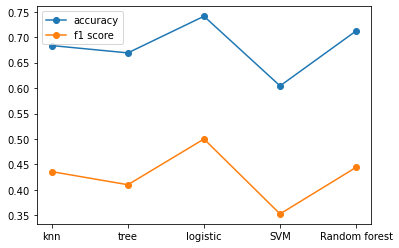

In [28]:
plt.plot(results["model"], results["accuracy"], '-o', label="accuracy")
plt.plot(results["model"], results["f1"], '-o', label="f1 score")
plt.legend()